In [1]:
import mglearn
import matplotlib.pyplot as plt
import numpy as np
import mglearn

/Users/yunhongmin/.pyenv/versions/3.7.4/envs/data-science/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/yunhongmin/.pyenv/versions/3.7.4/envs/data-science/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


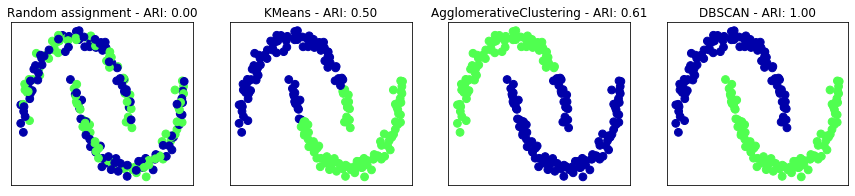

In [2]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples=200, noise=0.05, random_state= 0)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={'xticks': (), 'yticks': ()})
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(adjusted_rand_score(y, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__, adjusted_rand_score(y, clusters)))

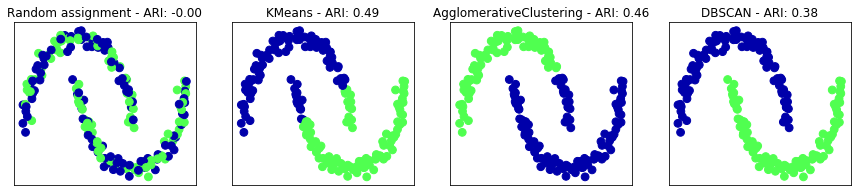

In [3]:
# real data usually have ground truth for unsupervised learning
# silhouette_score: measure compactness of cluster. max 1. not work for complex shape.

from sklearn.metrics.cluster import silhouette_score

X, y = make_moons(n_samples=200, noise=0.05, random_state= 0)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={'xticks': (), 'yticks': ()})
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))

axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(silhouette_score(X_scaled, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__, silhouette_score(X_scaled, clusters)))


Unique labels: [-1  0]
Number of points per cluster: [  32 2031]


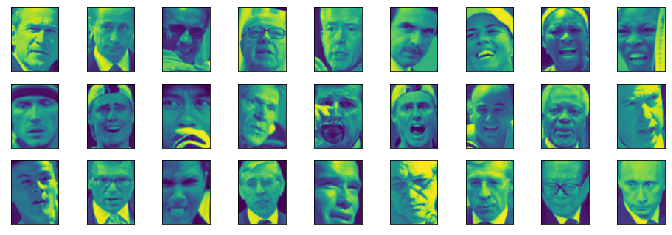

In [4]:
# feature extraction
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability -> important
X_people = X_people / 255.

# extract eigenfaces from lfw data and transform data
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_people)
X_pca = pca.transform(X_people)


dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))


# Count number of points in all clusters and noise.
# bincount doesn't allow negative numbers, so we need to add 1.
# The first number in the result corresponds to noise points. -> 32 noises
print("Number of points per cluster: {}".format(np.bincount(labels + 1)))


noise = X_people[labels==-1]
fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(12, 4))
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

In [5]:
for eps in[1,3,5,7,9,11,13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("Clusters present: {}".format(np.unique(labels)))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=1
Clusters present: [-1]
Cluster sizes: [2063]

eps=3
Clusters present: [-1]
Cluster sizes: [2063]

eps=5
Clusters present: [-1]
Cluster sizes: [2063]

eps=7
Clusters present: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
Cluster sizes: [2004    3   14    7    4    3    3    4    4    3    3    5    3    3]

eps=9
Clusters present: [-1  0  1  2]
Cluster sizes: [1307  750    3    3]

eps=11
Clusters present: [-1  0]
Cluster sizes: [ 413 1650]

eps=13
Clusters present: [-1  0]
Cluster sizes: [ 120 1943]


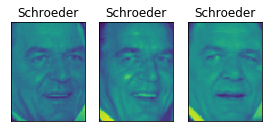

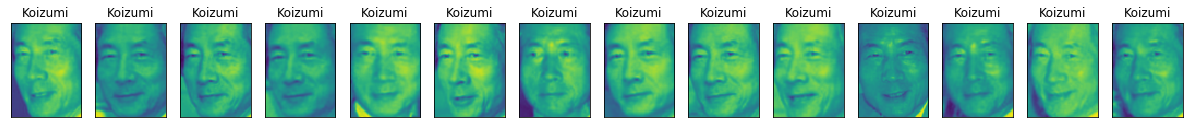

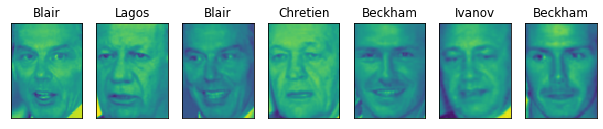

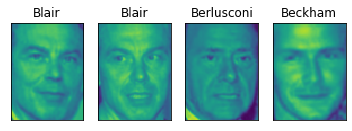

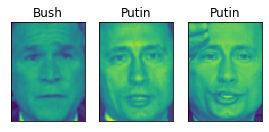

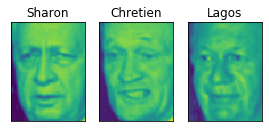

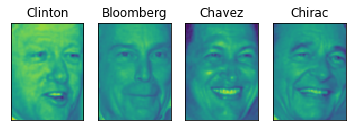

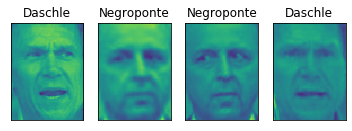

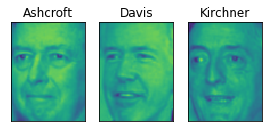

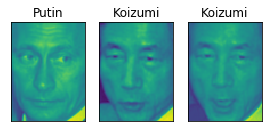

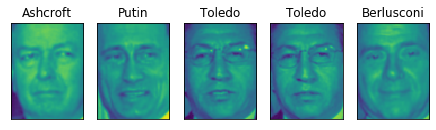

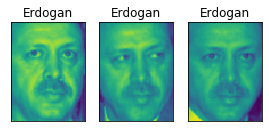

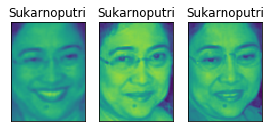

In [6]:
# check groups of small clustering numbers for eps=7
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)
for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4),
    subplot_kw={'xticks': (), 'yticks': ()})
    
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])